# Multiscale PV Recycling MILP

__author__ = "Natasha Jane Chrisandina, Funda Iseri, Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Natasha Jane Chrisandina", "Funda Iseri", "Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__maintainer__ = "Natasha Jane Chrisandina"
__email__ = "nchrisandina@tamu.edu"
__status__ = "Production"

## Problem Statement

The following case study considers one type of solar PV panel (crystalline silicon, c-Si) that is to be recycled into separate components. The goal is to maximize economic profit obtained from the recycling process.

Data source: https://www.sciencedirect.com/science/article/pii/S0927024822000162

Module imports

In [1]:
import sys
sys.path.append('src')

In [2]:
import pandas 
import numpy

from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process
from energiapy.components.location import Location
from energiapy.components.transport import Transport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.result import Result 
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import product
from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut

## Define Temporal Scale

Define temporal scales at different levels:
- 0 is annual, with 1 discretization
- 1 is daily, with 365 discretization

In [3]:
scales = TemporalScale(discretization_list=[1, 365])

## Define Resources

Define resources, which are things to be consumed, produced, stored, or sold. In this case, the feedstock is silicon PV and the products are the different major recyclable materials. We will assume that *glass* is a product in demand, whereas everything else can simply be sold.

In [4]:
SiPV_dummy = Resource(name = 'sipv_dummy', label='Silicon PV Dummy', price=50, basis = 'module', cons_max=13000)
SiPV = Resource(name = 'sipv', label='Silicon Photovoltaic', price=50, basis = 'module')
glass = Resource(name = 'glass', label='Recycled glass', revenue=100, basis = 'kg')
aluminum = Resource(name = 'al', label='Recycled aluminum', revenue=100, basis = 'kg', sell=True)
polymer = Resource(name = 'polymer', label='Recycled polymer', revenue=100, basis = 'kg', sell=True)
copper = Resource(name = 'cu', label='Recycled copper', revenue=100, basis = 'kg', sell=True)
silver = Resource(name = 'ag', label='Recycled silver', revenue=100, basis = 'kg', sell=True)
silicon = Resource(name = 'si', label='Recycled silicon', revenue=100, basis = 'kg', sell=True)
glass_dummy = Resource(name = 'glass_dummy', label='Recycled glass Dummy', revenue=100, basis = 'kg', demand=True, varying = [VaryingResource.DETERMINISTIC_DEMAND])
al_dummy = Resource(name = 'al_dummy', label='Recycled aluminum Dummy', revenue=100, basis = 'kg', demand=True, varying = [VaryingResource.DETERMINISTIC_DEMAND])


## Define Processes

Define processes, which are the different potential recycling processes. There are three types of process: FRELP, ASU, and Hybrid, and each process has two separate max production level to represent large-scale vs small-scale recycling.

The "collection" process is essentially a dummy process to represent PVs being shipped off from a collection center to recycling center locations. Glass_collect is the same, except for glass which is a demanded product

In [5]:
collection = Process(name = 'collection', label='dummy process', conversion = {SiPV_dummy: -1, SiPV: 1}, prod_max = 130000, capex = 0.001)
glass_collect = Process(name = 'glass_collection', label='dummy process for glass', conversion = {glass: -1, glass_dummy: 1}, prod_max = 10**6, capex = 0.001)
al_collect = Process(name = 'al_collection', label='dummy process for Al', conversion = {aluminum: -1, al_dummy: 1}, prod_max = 10**6, capex = 0.001)


FRELP = Process(name = 'FRELP', label='FRELP recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.17945, silver: 0.001739}, prod_max = 1300, capex = 4, vopex = 8, block='A')
ASU = Process(name = 'ASU', label='ASU recycling', conversion = {SiPV: -1, glass: 13.73625, polymer: 2.22, aluminum: 1.5651, silicon: 0.4995, copper: 0.15355, silver: 0.001369}, prod_max = 1300, prod_min = 1, capex = 17, vopex = 9, block='A')
hybrid = Process(name = 'hybrid', label='Hybrid recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.15355, silver: 0.001369}, prod_max = 1300, capex = 3, vopex = 7, block='A')


FRELP_big = Process(name = 'FRELP_big', label='big FRELP recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.17945, silver: 0.001739}, prod_max = 13000, capex = 3, vopex = 5, block='A')
ASU_big = Process(name = 'ASU_big', label='big ASU recycling', conversion = {SiPV: -1, glass: 13.73625, polymer: 2.22, aluminum: 1.5651, silicon: 0.4995, copper: 0.15355, silver: 0.001369}, prod_max = 13000, capex = 8, vopex = 6, block='A')
hybrid_big = Process(name = 'hybrid_big', label='big Hybrid recycling', conversion = {SiPV: -1, glass: 13.5975, polymer: 2.22, aluminum: 1.65501, silicon: 0.53835, copper: 0.15355, silver: 0.001369}, prod_max = 13000, capex = 3, vopex = 4, block='A')


## Define locations

demand_factor is the variations within demand for this particular resource at this location

In [6]:
import random 
glass_factor = pandas.DataFrame(data={'glass_dummy': [random.randrange(60, 100) for i in range(scales.discretization_list[1])]})
                                       
al_factor = pandas.DataFrame(data={'al_dummy' : [random.randrange(80,100) for i in range(scales.discretization_list[1])]})
                                       

In [7]:
cc1 = Location(name='cc1', label = 'Collection Center 1', scales = scales, processes = {collection})
cc2 = Location(name='cc2', label = 'Collection Center 2', scales = scales, processes = {collection})


rc1 = Location(name='rc1', label = 'Recycling Center 1', scales = scales, processes = {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big})
rc2 = Location(name='rc2', label = 'Recycling Center 2', scales = scales, processes = {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big})


gc1 = Location(name='gc1', label = 'Glass Recycling Center 1', scales = scales, processes= {glass_collect}, demand_factor= {glass_dummy: glass_factor}, demand_scale_level= 1)

ac1 = Location(name='ac1', label = 'Aluminum Recycling Center 1', scales = scales, processes= {al_collect}, demand_factor= {al_dummy: al_factor}, demand_scale_level= 1)


## Define transportation modes

In [8]:
Trans_PV = Transport(name = 'Trans_PV', resources = {SiPV}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport of PVs')
Trans_glass = Transport(name = 'Trans_glass', resources = {glass}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport for recycled glass')
Trans_al = Transport(name = 'Trans_al', resources = {aluminum}, trans_max = 10**6, trans_cost = 0.01, label = 'Transport for recycled aluminum') 


distance_matrix = [
    [100, 100, 200, 200],
    [100, 100, 200, 200],
    [0, 100, 100, 100],
    [100, 0, 100, 100]
    ]

transport_matrix = [
    [[Trans_PV], [Trans_PV], [], []],
    [[Trans_PV], [Trans_PV], [], []],
    [[], [], [Trans_glass], [Trans_al]],
    [[], [], [Trans_glass], [Trans_al] ]
]


network = Network(name = 'Network', label= 'Generic network', source_locations = [cc1, cc2, rc1, rc2], sink_locations = [rc1, rc2, gc1, ac1], distance_matrix = distance_matrix, transport_matrix= transport_matrix)

## Define scenario. 

Glass recycling center and aluminum recycling center have some level of demand that needs fulfilling. In the Scenario object, the baseline demand is defined. In the Location object, the variations in demand per scheduling time period is defined

In [9]:
genericScenario = Scenario(name = 'genericScenario', network = network, scales= scales, demand={ac1: {glass_dummy: 0, al_dummy: 10000}, gc1: {glass_dummy: 10000, al_dummy: 0}, rc1: {glass_dummy: 0, al_dummy: 0}, rc2: {glass_dummy:0, al_dummy: 0}}, label = 'genericScenario', network_scale_level = 0, purchase_scale_level = 1, scheduling_scale_level = 1, demand_scale_level = 1, expenditure_scale_level = 0)

## Optimize for cost

In [10]:
genericScenario.loc_res_dict

{'gc1': {'glass', 'glass_dummy'},
 'cc1': {'sipv', 'sipv_dummy'},
 'rc2': {'ag', 'al', 'cu', 'glass', 'polymer', 'si', 'sipv'},
 'rc1': {'ag', 'al', 'cu', 'glass', 'polymer', 'si', 'sipv'},
 'cc2': {'sipv', 'sipv_dummy'},
 'ac1': {'al', 'al_dummy'}}

In [11]:
milp_cost = formulate(scenario = genericScenario, constraints={Constraints.INVENTORY, Constraints.COST, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK}, objective=Objective.COST)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production
constraint production max
constraint production min
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location consumption
constraint location purchase
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint transport export
constraint transport import
constraint transport exp UB
constraint transport imp UB
constraint transport balance
constraint transport i

In [12]:
results_cost = solve(scenario = genericScenario, instance=milp_cost, solver='gurobi', print_solversteps=True, name = 'results')

Academic license - for non-commercial use only - expires 2023-07-20
Using license file C:\Users\nchrisandina\gurobi.lic
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to C:\Users\NCHRIS~1\AppData\Local\Temp\tmpr_1mao5k.log
   Prev:   Default: 
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 280490 rows, 306035 columns and 630251 nonzeros
Model fingerprint: 0x59b41506
Variable types: 305933 continuous, 102 integer (102 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+06]
Presolve removed 275573 rows and 301973 columns
Presolve time: 0.42s
Presolved: 4917 rows, 4062 columns, 19082 nonzeros
Variable types: 4060 continuous, 2 integer (2 b

## Optimize for demand

In [ ]:
milp_demand = formulate(scenario = genericScenario, constraints={Constraints.INVENTORY, Constraints.COST, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.TRANSPORT, Constraints.NETWORK}, objective=Objective.MAX_DISCHARGE, objective_resource = glass_dummy)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint nameplate inventory
constraint storage max
constraint storage min
constraint production mode
constraint nameplate production
constraint production max
constraint production min
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location consumption
constraint location purchase
constraint network production
constraint network discharge
constraint network consumption
constraint network purchase
constraint transport export
constraint transport import
constraint transport exp UB
constraint transport imp UB
constraint transport balance
constraint transport i

Specify that only one process gets chosen in RC1

Integer cut constraints can also be used to indicate that we need at least/at most X many processes in this location

In [ ]:
# milp_demand.constraint_block_integer_cut1 = constraint_block_integer_cut(
#     instance=milp_demand, network_scale_level=0, location=rc1, block='A', number=1, process_set=rc1.processes)

In [ ]:
results_demand = solve(scenario = genericScenario, instance=milp_demand, solver='gurobi', print_solversteps=True, name = 'results')

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to C:\Users\NCHRIS~1\AppData\Local\Temp\tmpz_1fck38.log
   Prev:   Default: 
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 80627 rows, 79877 columns and 221433 nonzeros
Model fingerprint: 0xb1c0f873
Variable types: 79833 continuous, 44 integer (44 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+03, 1e+06]
Presolve removed 80627 rows and 79877 columns
Presolve time: 0.07s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.12 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 1.29764e+08 

Optimal solution found (tolerance 1.00e-04)
Best 

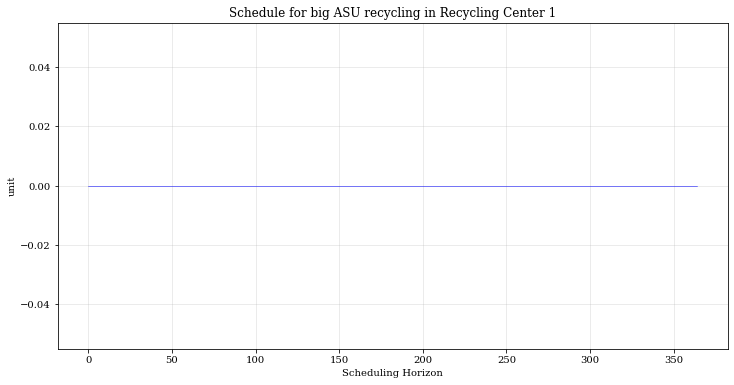

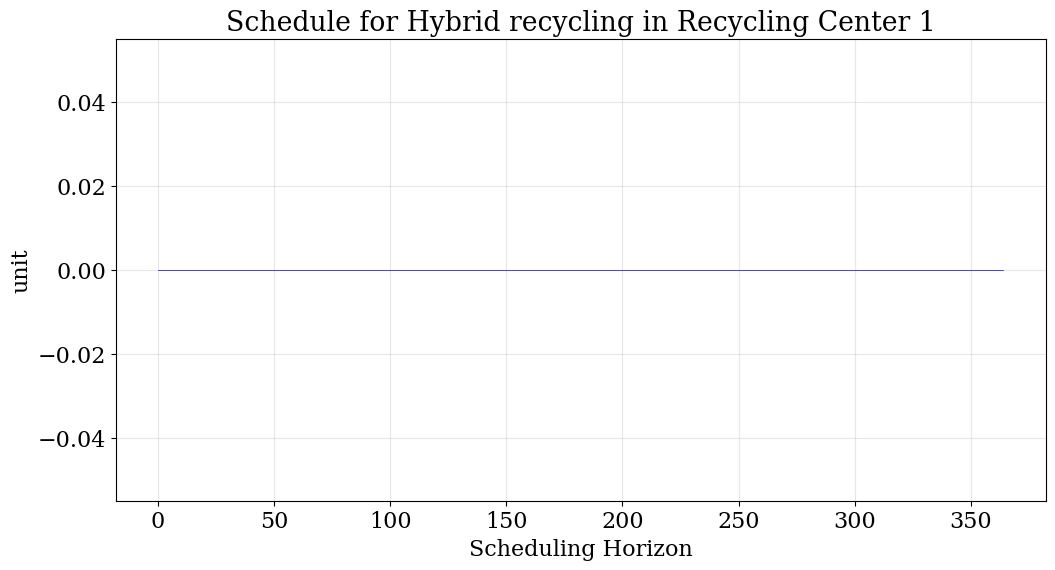

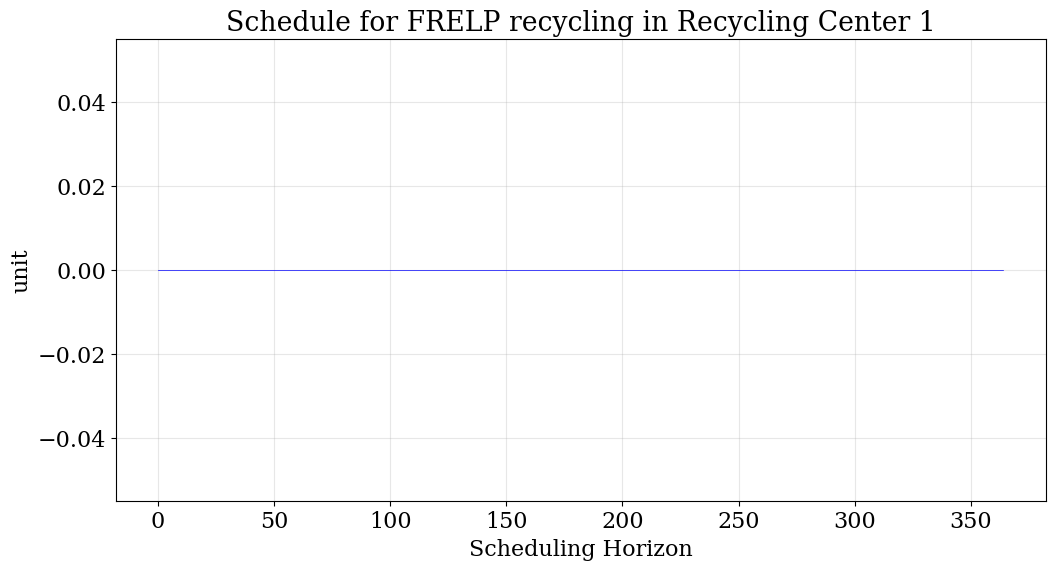

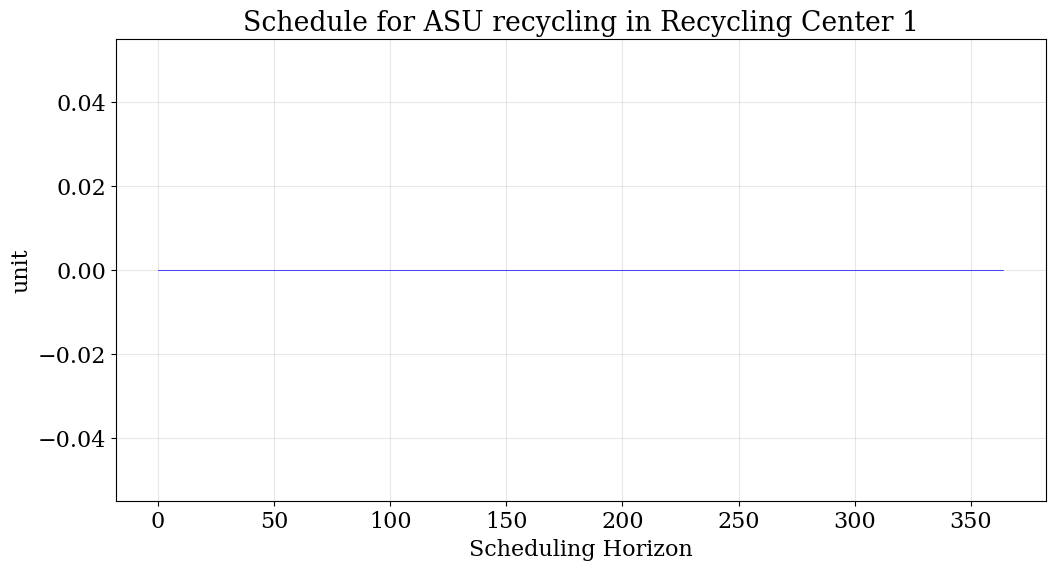

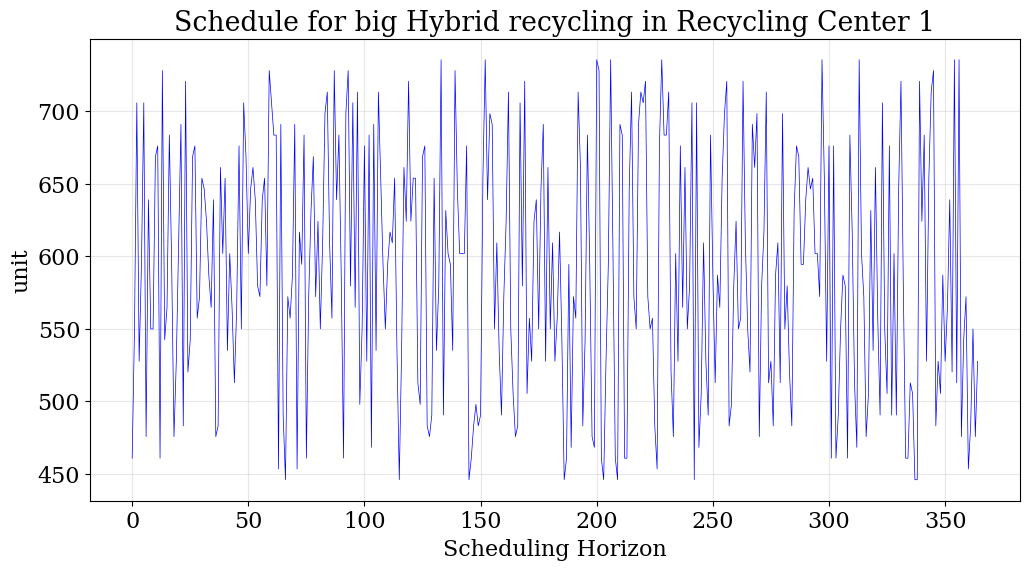

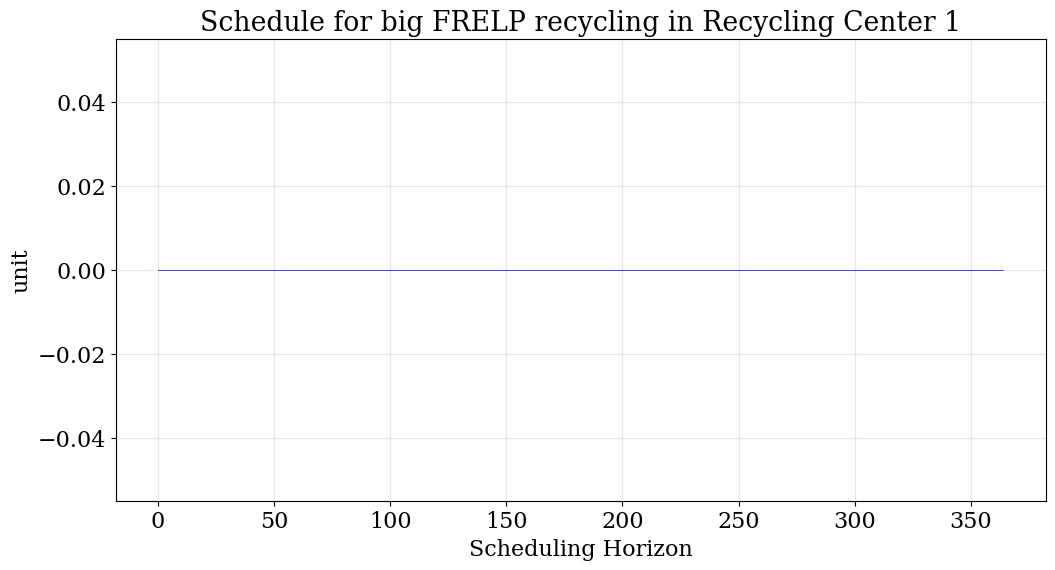

In [ ]:
for i in {FRELP, ASU, hybrid, FRELP_big, ASU_big, hybrid_big}:
    plot_results.schedule(location = 'rc1', component = i.name, results = results_cost, y_axis = 'P')

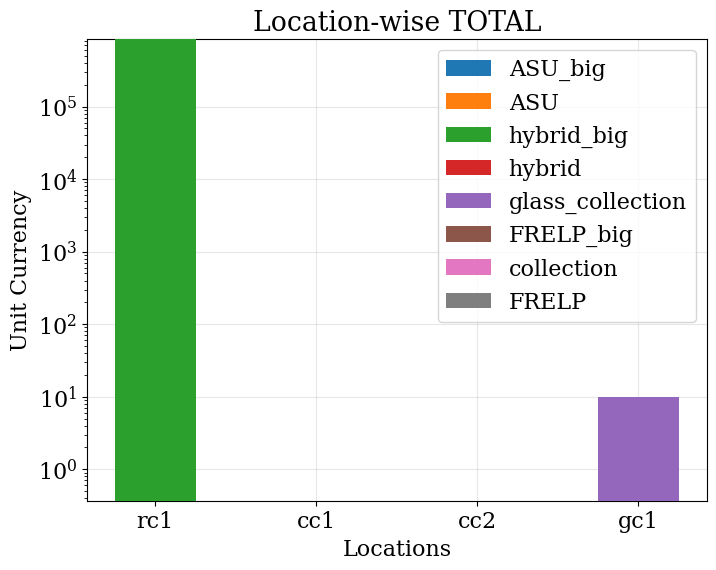

In [ ]:
plot_results.cost(results=results_cost, x=CostX.LOCATION_WISE,
                  y=CostY.TOTAL, location='rc1', fig_size=(8, 6))

[0.0, 0.0, 735.4293068578783, 0.0, 0.0, 0.0, 0.0, 0.0]


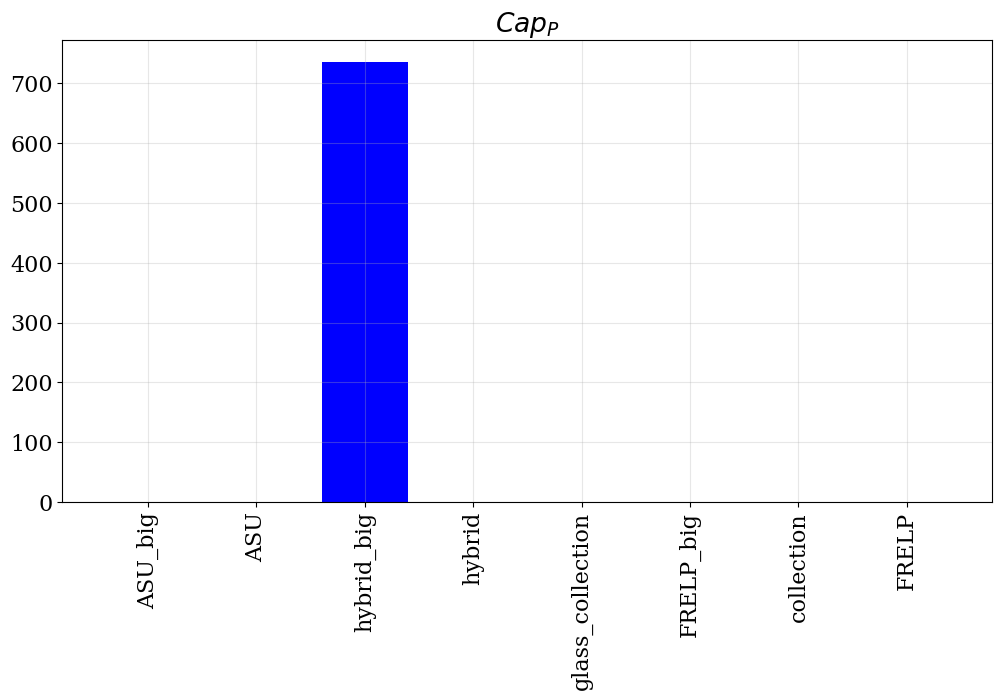

In [ ]:
plot_results.contribution(results= results_cost, location= 'rc1', y_axis= 'Cap_P')

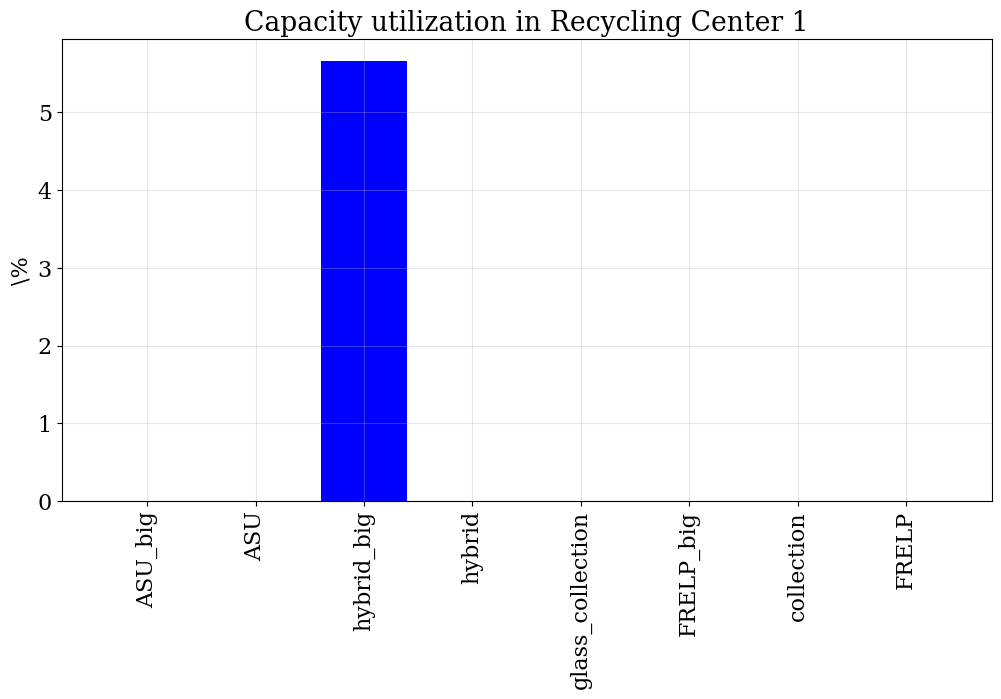

In [ ]:
plot_results.capacity_utilization(results=results_cost, location='rc1')

In [ ]:
735.4293068578783/13000

0.05657148514291371

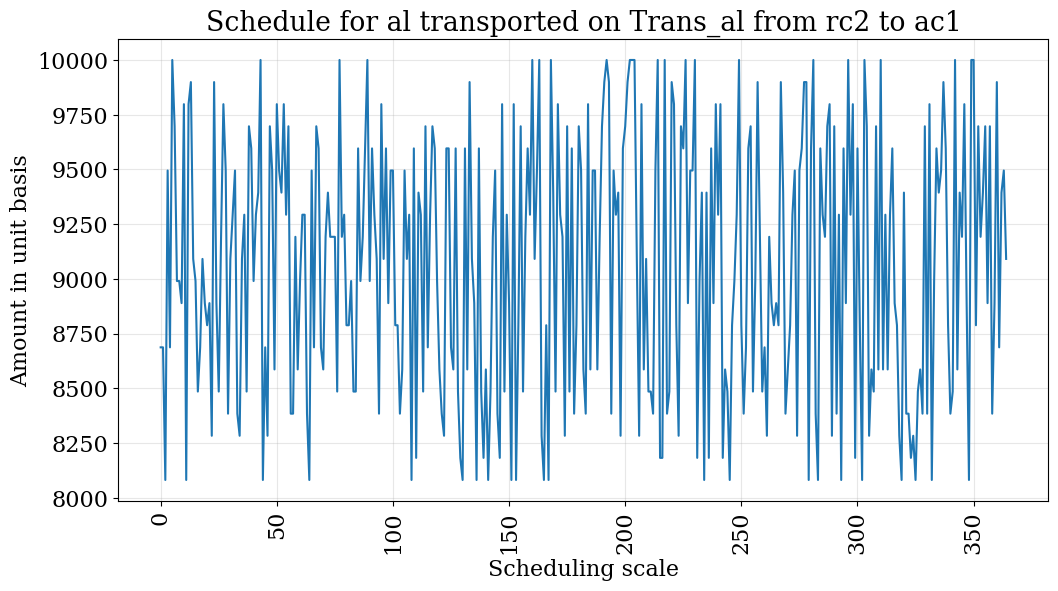

In [16]:
plot_results.transport(results=results_cost, source= 'rc2', sink = 'ac1', resource= 'al', transport='Trans_al')